### Machine learning linear regression : Food Delivery Time Prediction

In [1]:
!pip install -r requirements.txt

In [2]:
#import required libraries
import pickle
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
import lightgbm as lgb


In [3]:
# Download the dataset
!kaggle datasets download -d denkuznetz/food-delivery-time-prediction -p ../data
!unzip ../data/food-delivery-time-prediction.zip -d ../data

Dataset URL: https://www.kaggle.com/datasets/denkuznetz/food-delivery-time-prediction
License(s): apache-2.0
  0%|                                               | 0.00/11.6k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 11.6k/11.6k [00:00<00:00, 19.8MB/s]
Archive:  ../data/food-delivery-time-prediction.zip
  inflating: ../data/Food_Delivery_Times.csv  


### Data Preparation

In [3]:
#load the dataset
df = pd.read_csv("../data/Food_Delivery_Times.csv")

In [4]:
len(df)

1000

The dataset contains 1000 rows and 9 columns. Let's take a look at the first few rows of the dataset.

In [5]:
df.head(1)

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43


Convert column names to lowercase and remove spaces

In [6]:
# Convert column names to lowercase
df.columns = [col.lower() for col in df.columns]
df.head(1)

,order_id,distance_km,weather,traffic_level,time_of_day,vehicle_type,preparation_time_min,courier_experience_yrs,delivery_time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43


In [7]:
df.dtypes

order_id                    int64
distance_km               float64
weather                    object
traffic_level              object
time_of_day                object
vehicle_type               object
preparation_time_min        int64
courier_experience_yrs    float64
delivery_time_min           int64
dtype: object

In [8]:
# Remove order_id as it's not relevant for analysis
df = df.drop('order_id', axis=1)


In [9]:
categorical_features = ['weather','traffic_level','time_of_day','vehicle_type']
numerical_features = ['distance_km','preparation_time_min','courier_experience_yrs','delivery_time_min']

In [10]:
print(df.describe().round(2))   

       distance_km  preparation_time_min  courier_experience_yrs  \
count      1000.00               1000.00                  970.00   
mean         10.06                 16.98                    4.58   
std           5.70                  7.20                    2.91   
min           0.59                  5.00                    0.00   
25%           5.11                 11.00                    2.00   
50%          10.19                 17.00                    5.00   
75%          15.02                 23.00                    7.00   
max          19.99                 29.00                    9.00   

       delivery_time_min  
count            1000.00  
mean               56.73  
std                22.07  
min                 8.00  
25%                41.00  
50%                55.50  
75%                71.00  
max               153.00  


### EDA - Exploratory Data Analysis

Let's examine the unique values in each categorical feature to better understand our dataset. This will help us identify potential data quality issues and understand the distribution of categories.

In [11]:
print("Unique values in each categorical feature:")
for col in categorical_features:
    print(f"{col}: {df[col].unique()}")

Unique values in each categorical feature:
weather: ['Windy' 'Clear' 'Foggy' 'Rainy' 'Snowy' nan]
traffic_level: ['Low' 'Medium' 'High' nan]
time_of_day: ['Afternoon' 'Evening' 'Night' 'Morning' nan]
vehicle_type: ['Scooter' 'Bike' 'Car']


Now, lets check for missing values in the dataset and address them.

In [12]:
df.isnull().sum()

distance_km                0
weather                   30
traffic_level             30
time_of_day               30
vehicle_type               0
preparation_time_min       0
courier_experience_yrs    30
delivery_time_min          0
dtype: int64

Handling Missing Values
For this dataset:
- Weather conditions, traffic level, and time of day are likely random missing values
- Courier experience could indicate new hires when missing

Recommended approach:
- Use mode imputation for categorical variables as they represent common conditions
- Use median for courier_experience_yrs as it's less sensitive to outliers than mean

In [13]:
# Fill missing missing values values with mode (most frequent value)
df['weather'] = df['weather'].fillna(df['weather'].mode()[0])
df['traffic_level'] = df['traffic_level'].fillna(df['traffic_level'].mode()[0])
df['time_of_day'] = df['time_of_day'].fillna(df['time_of_day'].mode()[0])

# Fill missing missing values values with median (middle value)
df['courier_experience_yrs'] = df['courier_experience_yrs'].fillna(df['courier_experience_yrs'].median())

In [14]:
df.isnull().sum()

distance_km               0
weather                   0
traffic_level             0
time_of_day               0
vehicle_type              0
preparation_time_min      0
courier_experience_yrs    0
delivery_time_min         0
dtype: int64

In [15]:
df['delivery_time_min'].value_counts()

delivery_time_min
71     23
48     22
44     22
43     21
51     21
       ..
153     1
13      1
123     1
8       1
114     1
Name: count, Length: 108, dtype: int64

There is 108 different delivery times in the dataset. The most frequent is 71 minutes for a delivery. Let's check the distribution of delivery times.

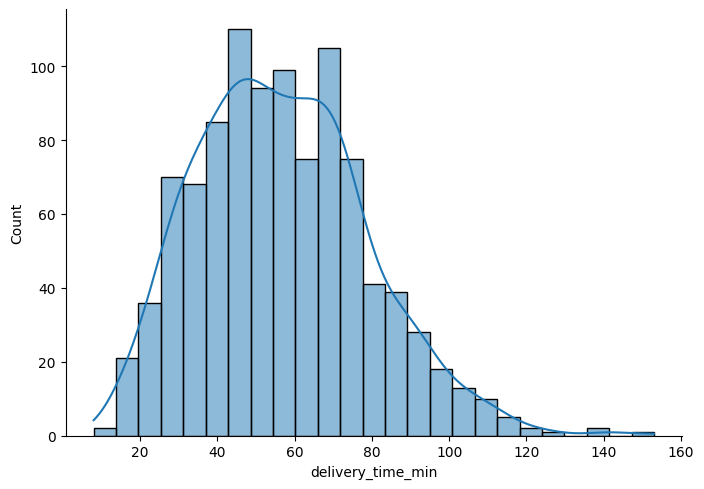

In [16]:
sns.displot(x='delivery_time_min',data=df,aspect=10/7,kde=True)

**Distribution Shape**

The histogram appears to be unimodal (single peak) and positively skewed (tail extending to the right). This indicates that most delivery times fall within a certain range, but there are less frequent instances of much longer delivery times pulling the distribution's tail to the right.

**Central Tendency**

**Mode:** The modal class (most frequent bin) seems to be in the 60-70 minute range. This suggests the most common delivery times fall within this interval.

**Median:** Since the distribution is skewed, the median (middle value) is likely to be slightly higher than the mode. It probably lies somewhere in the 70-80 minute range because the tail is pulling the mean and median towards the higher values.

**Mean:** The mean (average) will be the most affected by the long tail and is expected to be greater than the median and mode. It's likely located somewhere above 80 minutes.


**Spread/Variability**

**Range:** The data spans from around 20 minutes to a little over 160 minutes, giving a wide range. 

**Interquartile Range (IQR):** Due to the skewness, IQR would be a more appropriate measure of spread than the standard deviation. It's difficult to estimate visually but would likely capture the spread of the central 50% of the data, offering a better representation of the variability of typical delivery times.

**Outliers:** The data points in the far right tail (beyond 120 minutes, for example) could be considered potential outliers. These warrant further investigation to understand if they represent genuine extreme delivery times or if they are due to errors in data collection or specific circumstances (e.g., traffic, weather).

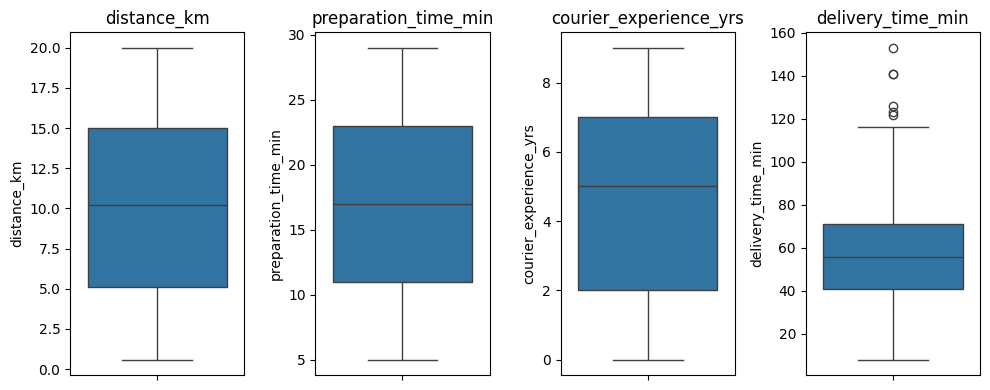

In [17]:
plt.figure(figsize=(10, 4))

for i, col in enumerate(numerical_features):
    plt.subplot(1, len(numerical_features), i + 1)
    sns.boxplot(y=df[col])
    plt.title(col)

plt.tight_layout()
plt.show()

1. distance_km (Distance in Kilometers):
* Median: The median distance appears to be around 12-13 km. This represents the typical distance for the deliveries in the dataset.
* Interquartile Range (IQR): The IQR (the box's height) spans roughly from 7 km to 17 km. This indicates that the middle 50% of deliveries fall within this distance range. This is a substantial spread, suggesting considerable variability in delivery distances.
* Range: The full range of distances extends from nearly 0 km to about 20 km.
* Potential Outliers: There are no apparent outliers on the lower end. However, the maximum distance of 20 km could be considered a potential outlier, depending on the context. It's significantly higher than the rest of the data.
2. preparation_time_min (Preparation Time in Minutes):
* Median: The median preparation time is approximately 15 minutes.
* IQR: The IQR ranges from about 10 minutes to 20 minutes. This indicates a moderate amount of variability in preparation times.
* Range: The data spans from roughly 5 minutes to 30 minutes.
* Potential Outliers: The maximum value of 30 minutes could be considered a potential outlier. It's notably higher than the rest of the distribution.
3. courier_experience_yrs (Courier Experience in Years):
* Median: The median courier experience is around 5 years.
* IQR: The IQR extends from approximately 2 to 8 years. This shows a reasonable range of experience levels among the couriers.
* Range: The experience ranges from 0 years (presumably new couriers) to about 8 years.
* Potential Outliers: There are no clear outliers in this variable.
4. delivery_time_min (Delivery Time in Minutes):
* Median: The median delivery time is roughly 60 minutes.
* IQR: The IQR ranges from about 40 minutes to 80 minutes. This demonstrates significant variability in delivery times.
* Range: The data spans from approximately 20 minutes to 160 minutes.
* Potential Outliers: There are several potential outliers on the higher end, above 100 minutes. These extreme values suggest that some deliveries experienced substantial delays.

/tmp/ipykernel_10163/4042389426.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df,x='courier_experience_yrs',y='delivery_time_min',palette='plasma')


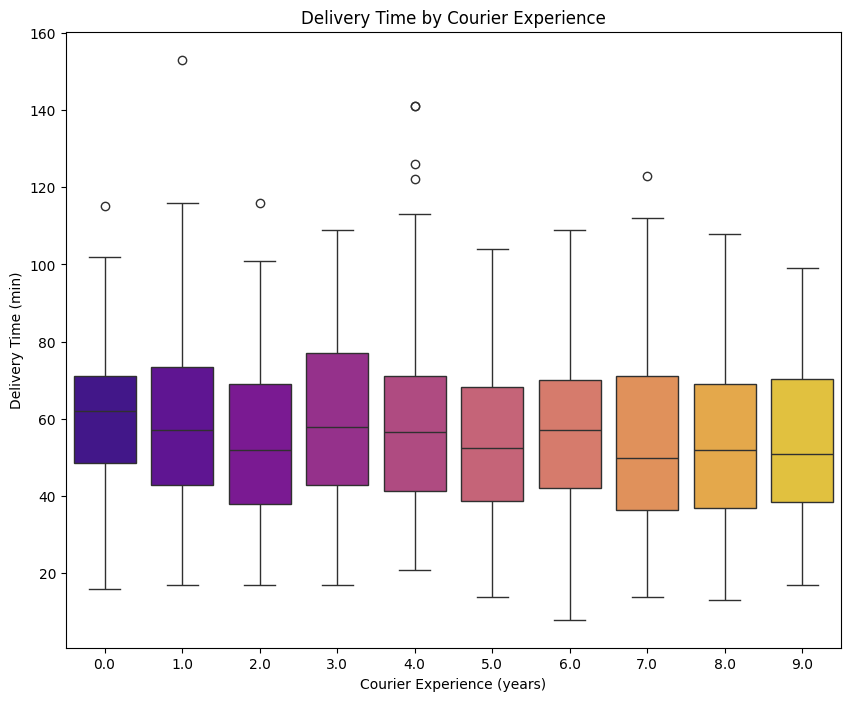

In [18]:
plt.figure(figsize=(10,8))
sns.boxplot(data=df,x='courier_experience_yrs',y='delivery_time_min',palette='plasma')
plt.title("Delivery Time by Courier Experience")
plt.xlabel("Courier Experience (years)")
plt.ylabel("Delivery Time (min)")
plt.show()

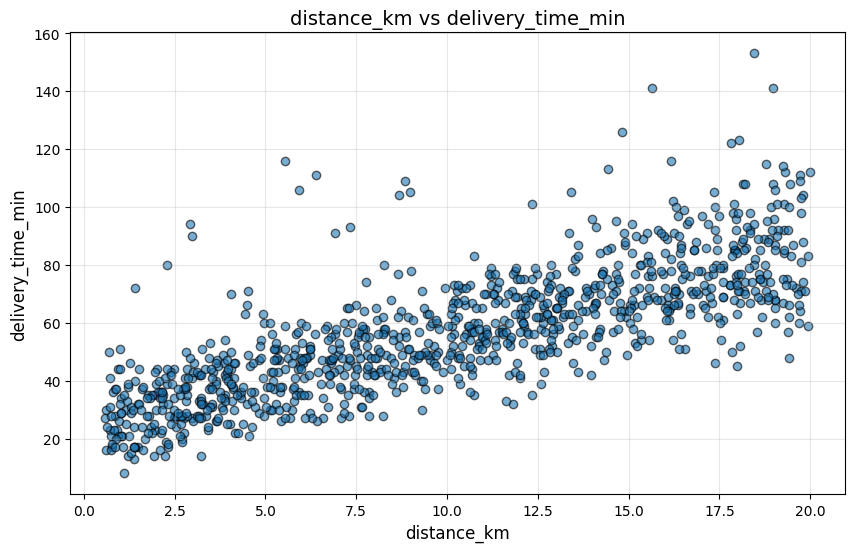

In [19]:
plt.figure(figsize=(10, 6))
plt.scatter(df["distance_km"], df["delivery_time_min"], alpha=0.6, edgecolor='k')
plt.title("distance_km vs delivery_time_min", fontsize=14)
plt.xlabel("distance_km", fontsize=12)
plt.ylabel("delivery_time_min", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

This scatter plot visualizes the relationship between distance_km (distance in kilometers) and delivery_time_min (delivery time in minutes).  

Positive Correlation: There appears to be a positive correlation between distance and delivery time. As the distance increases, the delivery time tends to increase as well. This is a logical and expected relationship.

The graph shows that delivery time tends to increase with distance, but there's a fair amount of variability due to other factors.  The presence of potential outliers suggests the possibility of unusual events impacting delivery times.

                        distance_km  preparation_time_min  \
distance_km                1.000000             -0.009025   
preparation_time_min      -0.009025              1.000000   
courier_experience_yrs    -0.005951             -0.031124   
delivery_time_min          0.816535              0.305535   

                        courier_experience_yrs  delivery_time_min  
distance_km                          -0.005951           0.816535  
preparation_time_min                 -0.031124           0.305535  
courier_experience_yrs                1.000000          -0.085540  
delivery_time_min                    -0.085540           1.000000  


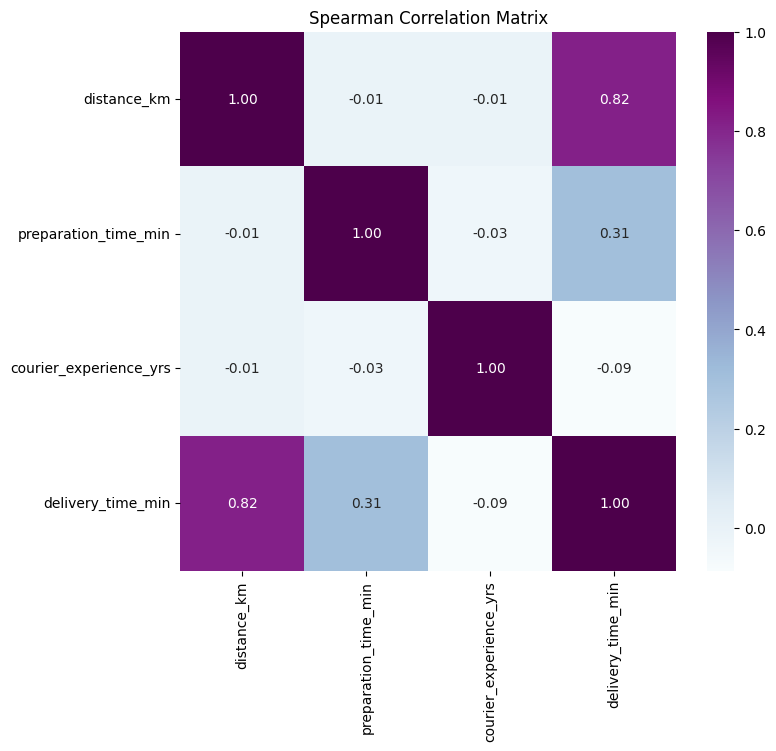

In [20]:
numeric_df = df[numerical_features]
spearman_corr = numeric_df.corr(method='spearman')

print(spearman_corr)

plt.figure(figsize=(8, 7))
sns.heatmap(spearman_corr, annot=True, fmt=".2f", cmap='BuPu' , cbar=True)
plt.title('Spearman Correlation Matrix')
plt.show()

Key Observations:

`distance_km` and `delivery_time_min` (0.82): There's a strong positive correlation between distance and delivery time. This aligns with our expectation that longer distances generally take longer to deliver.

`preparation_time_min` and `delivery_time_min` (0.31): There's a moderate positive correlation between preparation time and delivery time. This suggests that longer preparation times tend to be associated with longer delivery times, possibly due to the order being ready later.

Weak/No Correlation:  Most other pairs show very weak or no linear correlation. For example:

`courier_experience_yrs` with `delivery_time_min` (-0.09) shows a very weak negative correlation, suggesting that more experience might slightly reduce delivery time, but the relationship is very weak.

`distance_km` with `preparation_time_min` (-0.01) shows almost no correlation.

### Encode categorical features

In [21]:
df_encoded = pd.get_dummies(
    df,
    columns=categorical_features,
    drop_first=True
)

print("\nEncoded Data")
display(df_encoded.head())


Encoded Data


,distance_km,preparation_time_min,courier_experience_yrs,delivery_time_min,weather_Foggy,weather_Rainy,weather_Snowy,weather_Windy,traffic_level_Low,traffic_level_Medium,time_of_day_Evening,time_of_day_Morning,time_of_day_Night,vehicle_type_Car,vehicle_type_Scooter
0,7.93,12,1.0,43,False,False,False,True,True,False,False,False,False,False,True
1,16.42,20,2.0,84,False,False,False,False,False,True,True,False,False,False,False
2,9.52,28,1.0,59,True,False,False,False,True,False,False,False,True,False,True
3,7.44,5,1.0,37,False,True,False,False,False,True,False,False,False,False,True
4,19.03,16,5.0,68,False,False,False,False,True,False,False,True,False,False,False


### Setting up the validation framework

In [22]:
# Split the original dataframe 'df' into two parts: 
# 'df_full_train' (80% of the data) and 'df_test' (20% of the data)
df_full_train, df_test = train_test_split(df_encoded, test_size=0.2, random_state=1)

# Further split 'df_full_train' into 'df_train' (75% of df_full_train) 
# and 'df_val' (25% of df_full_train)
# This means 'df_train' is 60% of the original data and 'df_val' is 20% of the original data
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [23]:
len(df_train), len(df_val), len(df_test)

(600, 200, 200)

In [24]:
print("\nTrain shape:", df_train.shape, "Test shape:", df_test.shape, "Validation shape:", df_val.shape)


Train shape: (600, 15) Test shape: (200, 15) Validation shape: (200, 15)


In [25]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.delivery_time_min.values
y_val = df_val.delivery_time_min.values
y_test = df_test.delivery_time_min.values

del df_train['delivery_time_min']   
del df_val['delivery_time_min']
del df_test['delivery_time_min']

### Scale Numeric Columns
Common benefits of scaling numeric features in regression include:
- Equal treatment of features: Without scaling, variables with larger ranges could dominate those with smaller ranges
- Improved gradient descent convergence: Scaled features help optimization algorithms converge faster and more reliably
- Better numerical stability: Prevents computational issues that can arise with very large or small numbers
- Model interpretability: Makes it easier to compare feature importance and coefficients

In [26]:
numerical_features.remove('delivery_time_min')

scaler = StandardScaler()
df_train[numerical_features] = scaler.fit_transform(df_train[numerical_features])
df_val[numerical_features] = scaler.transform(df_val[numerical_features])
df_test[numerical_features] = scaler.transform(df_test[numerical_features])

### Train models

In [27]:
def evaluate_model_performance(regressor, model_name):
    regressor.fit(df_train, y_train)
    
    # Evaluate on validation set
    y_val_pred = regressor.predict(df_val)

    mse = mean_squared_error(y_val, y_val_pred)
    rmse = np.sqrt(mse)
    r2score = r2_score(y_val, y_val_pred)
    
    print(f"Mean Squared Error on validation set for {model_name} is: ", round(rmse, 2))
    print(f"R2 Score on validation set for {model_name} is: ", round(r2score, 2))
    
    return regressor

### Model 1: Linear Regression

In [28]:
lr = LinearRegression()
evaluate_model_performance(lr, "Linear Regression")

Mean Squared Error on validation set for Linear Regression is:  11.3
R2 Score on validation set for Linear Regression is:  0.76


LinearRegression()

### Model 2: Ridge Regression

In [29]:
ridge = Ridge()
evaluate_model_performance(lr, "Ridge Regression")

Mean Squared Error on validation set for Ridge Regression is:  11.3
R2 Score on validation set for Ridge Regression is:  0.76


LinearRegression()

Ridge hyperparameter tuning

In [30]:
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}  

grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error') 

# Fit the GridSearchCV object (it will train and evaluate multiple models)
grid_search.fit(df_train, y_train)

# Get the best model (the one with the best hyperparameter)
best_ridge_model = grid_search.best_estimator_
print("Best Ridge Model: ", grid_search.best_params_)
evaluate_model_performance(best_ridge_model, "Ridge Regression with Hyperparameter Tuning")

Best Ridge Model:  {'alpha': 1}
Mean Squared Error on validation set for Ridge Regression with Hyperparameter Tuning is:  11.3
R2 Score on validation set for Ridge Regression with Hyperparameter Tuning is:  0.76


Ridge(alpha=1)

### Model 3: XGBoost

In [34]:
param_xgb = {
    'n_estimators': [100, 200, 300, 400],  
    'learning_rate': [0.1, 0.2, 0.3, 0.4],  
    'max_depth': [3, 5, 10]
    }


def create_model(n_estimators, learning_rate, max_depth):
    xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', 
                                 eval_metric='mae', 
                                 n_estimators=n_estimators,
                                 learning_rate=learning_rate,
                                 max_depth=max_depth,)
    return xgb_regressor

def search_best_params():
    best_params = {}
    best_rmse = float('inf')
    best_mse = float('inf')
    for n_estimators in param_xgb['n_estimators']:
        for learning_rate in param_xgb['learning_rate']:
            for max_depth in param_xgb['max_depth']:
                xgb_regressor = create_model(n_estimators, learning_rate, max_depth)
                xgb_regressor.fit(df_train, y_train)
                y_val_pred = xgb_regressor.predict(df_val)
                rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

                if rmse < best_rmse:
                    best_rmse = rmse
                    best_params = {'n_estimators': n_estimators, 'learning_rate': learning_rate, 'max_depth': max_depth}
    return best_params

    # for n_estimators in param_xgb['n_estimators']:
    #     for learning_rate in param_xgb['learning_rate']:
    #         for max_depth in param_xgb['max_depth']:
    #             xgb_regressor = create_model(n_estimators, learning_rate, max_depth)
    #             print(f"Training model with n_estimators={n_estimators}, learning_rate={learning_rate}, max_depth={max_depth}")
    #             evaluate_model_performance(xgb_regressor, "XGBoost")
    #             print("\n")


In [35]:
best_xgb_params = search_best_params()

In [36]:
xgb_model = create_model(n_estimators=best_xgb_params['n_estimators'], 
                             learning_rate=best_xgb_params['learning_rate'], 
                             max_depth=best_xgb_params['max_depth'])

In [37]:
evaluate_model_performance(xgb_model, "XGBoost")

Mean Squared Error on validation set for XGBoost is:  12.2
R2 Score on validation set for XGBoost is:  0.72


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Model 4: Random forest

In [38]:
rfr = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=3)      

evaluate_model_performance(rfr, "Random Forest")

Mean Squared Error on validation set for Random Forest is:  13.36
R2 Score on validation set for Random Forest is:  0.67


RandomForestRegressor(max_depth=3, n_jobs=-1, random_state=42)

In [41]:
param_xgb = {
    'n_estimators': [100, 200, 300, 400],  
    'max_depth': [3, 5, 10]
    }


def create_model(n_estimators, max_depth):
    model = RandomForestRegressor(
                                 n_estimators=n_estimators,
                                 max_depth=max_depth,)
    return model

def search_best_params():
    best_params = {}
    best_rmse = float('inf')
    for n_estimators in param_xgb['n_estimators']:
        for max_depth in param_xgb['max_depth']:
            model = create_model(n_estimators, max_depth)
            model.fit(df_train, y_train)
            y_val_pred = model.predict(df_val)
            rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

            if rmse < best_rmse:
                best_rmse = rmse
                best_params = {'n_estimators': n_estimators, 'max_depth': max_depth}
    return best_params

In [42]:
best_rfr_params = search_best_params()

In [43]:
print("Best Random Forest Model: ", best_rfr_params)

Best Random Forest Model:  {'n_estimators': 100, 'max_depth': 5}


In [44]:
rfr = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1, max_depth=10)      
evaluate_model_performance(rfr, "Random Forest")

Mean Squared Error on validation set for Random Forest is:  12.8
R2 Score on validation set for Random Forest is:  0.69


RandomForestRegressor(max_depth=10, n_estimators=200, n_jobs=-1,
                      random_state=42)

In conclusion, comparing the R2 Scores of the models, we can see that the ridge regression model after hyperparameter tuning has the highest R2 Score of 0.76. This means that the ridge regression model explains 76% of the variance in the target variable (delivery time). The XGBoost model also performs well with an R2 Score of 0.72. The linear regression model has an R2 Score of 0.71, while the random forest model has an R2 Score of 0.69.

### Use the model on the test set

In [45]:
#Concatenate the training and validation dataframes
df_full_train = pd.concat([df_train, df_val])
df_full_train = df_full_train.reset_index(drop=True)
X_full_train = df_full_train
X_full_train.shape

(800, 14)

In [46]:
y_full_train = np.concatenate([y_train, y_val]) 
y_full_train.shape

(800,)

In [47]:
df_test.shape

(200, 14)

In [48]:
y_test.shape

(200,)

In [49]:
alpha=1
ridge = Ridge(alpha=alpha, random_state=1)
ridge.fit(X_full_train, y_full_train)
y_test_pred = ridge.predict(df_test)
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
r2score = r2_score(y_test, y_test_pred)

print(f"Mean Squared Error on test set for Ridge Regression is: {round(rmse,2)}")
print(f"R2 Score on test set for Ridge Regression is: {round(r2score,2)}")

Mean Squared Error on test set for Ridge Regression is: 11.63
R2 Score on test set for Ridge Regression is: 0.73


In [61]:
# Select a single row from the test set
single_row = df_test.iloc[0]

# Get the actual premium price for the selected row
actual_delivery_time = y_test[0]

# Reshape the single row to match the expected input shape for the model
single_row_reshaped = single_row.values.reshape(1, -1)

# Predict the premium price using the trained Ridge model
predicted_delivery_time = ridge.predict(single_row_reshaped)[0]

print(f"Actual Premium Price: {actual_delivery_time}")
print(f"Predicted Premium Price: {predicted_delivery_time}")

Actual Premium Price: 80
Predicted Premium Price: 80.54198201178409


/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(


### Save the model


In [62]:
test_data = single_row_reshaped

In [63]:
# Set the output file path
output_file = '../model/ridge_model.bin'

# Open the file in write-binary mode
with open(output_file, 'wb') as f_out:
    # Serialize and save the Ridge model and test data to the file
    pickle.dump((ridge, test_data), f_out)

print(f'Model saved to {output_file}')

Model saved to ../model/ridge_model.bin


In [64]:
#load the model
input_file = '../model/ridge_model.bin'
with open(input_file, 'rb') as f_in: 
    model, test_data = pickle.load(f_in)

In [65]:
model

Ridge(alpha=1, random_state=1)

In [67]:
test_data

array([[1.3480748147629118, 0.2824626342792807, -0.5509984080885895,
        False, False, False, False, False, True, False, True, False,
        False, True]], dtype=object)